<a href="https://colab.research.google.com/github/andrea212023/ML-Kis/blob/main/HW_LSTM_KIS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Давайте подивимося, як LSTM можна використовувати для побудови нейронної мережі прогнозування часових.

Будемо працювати з задачею прогнозування кількості пасажирів міжнародних авіаліній. З цим набором даних ми вже працювали в лекції "Time Series Analysis" і ви зможете порівняти результати :)

Задача полягає в тому, щоб за заданими роком і місяцем передбачити кількість пасажирів міжнародних авіаліній в одиницях виміру 1,000. Дані охоплюють період з січня 1949 року по грудень 1960 року, тобто 12 років, зі 144 спостереженнями.

Це регресійна задача. Тобто, знаючи кількість пасажирів (в тисячах) за останні місяці, можна передбачити, якою буде кількість пасажирів у наступному місяці. Набір даних має лише одну характеристику: "Кількість пасажирів" - `Passengers`.

Далі вже наведений код для читання даних, але нам їх ще треба буде трошки обробити.

In [23]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

In [24]:
# Loading the data
url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv"
df = pd.read_csv(url)
df.set_index('Month', inplace=True)
display(df.head())

,Passengers
Month,
1949-01,112
1949-02,118
1949-03,132
1949-04,129
1949-05,121


**Завдання 1.** Створіть змінну типу `numpy.ndarray`, яка містить значення кількості пасажирів в форматі `float32`. Такий формат даних нам треба для тренування нейромережі.

In [25]:
# Converting the Passengers column to a numpy array of type float32
passengers_array = np.array(df['Passengers'], dtype=np.float32)

# Checking the result
print(passengers_array)
print(passengers_array.dtype)

[112. 118. 132. 129. 121. 135. 148. 148. 136. 119. 104. 118. 115. 126.
 141. 135. 125. 149. 170. 170. 158. 133. 114. 140. 145. 150. 178. 163.
 172. 178. 199. 199. 184. 162. 146. 166. 171. 180. 193. 181. 183. 218.
 230. 242. 209. 191. 172. 194. 196. 196. 236. 235. 229. 243. 264. 272.
 237. 211. 180. 201. 204. 188. 235. 227. 234. 264. 302. 293. 259. 229.
 203. 229. 242. 233. 267. 269. 270. 315. 364. 347. 312. 274. 237. 278.
 284. 277. 317. 313. 318. 374. 413. 405. 355. 306. 271. 306. 315. 301.
 356. 348. 355. 422. 465. 467. 404. 347. 305. 336. 340. 318. 362. 348.
 363. 435. 491. 505. 404. 359. 310. 337. 360. 342. 406. 396. 420. 472.
 548. 559. 463. 407. 362. 405. 417. 391. 419. 461. 472. 535. 622. 606.
 508. 461. 390. 432.]
float32


Очікуваний результат:
```array([112., 118., 132., 129., 121.], dtype=float32)```

**Завдання 2**. Розбийте дані на тренувальні і валідаційні у співвідношенні 67% йде у тренування, 33 - у валідацію. Памʼятаємо, що ми працюємо з tim series, відповідно, навчаємось на давніших, валідуємось - на новіших.

In [26]:
# Determine the index to split the data
split_index = int(len(passengers_array) * 0.67)

# Split the data into training and validation sets
train_data = passengers_array[:split_index]
val_data = passengers_array[split_index:]

# Display the sizes of the training and validation sets
print(f"Training data size: {len(train_data)}")
print(f"Validation data size: {len(val_data)}")

# Optionally, print the first few values of each set to verify
print("Training data:", train_data[:5])
print("Validation data:", val_data[:5])

Training data size: 96
Validation data size: 48
Training data: [112. 118. 132. 129. 121.]
Validation data: [315. 301. 356. 348. 355.]


**Завдання 3**.

Реалізуйте функцію `create_dataset`, яка перетворить одномірний часовий ряд (набір даних) у формат, придатний для тренування нейромережі.

Функція повинна приймати два аргументи:
- `dataset` — numpy-масив часового ряду,
- `lookback` — кількість попередніх кроків, які використовуватимуться для передбачення.

Функція повинна повернути два **тензори** PyTorch:
- `X` — набір ознак (вікно попередніх значень),
- `y` — цільові значення (наступні після вікна кроки).

Дані ми будемо подавати моделі в наступному форматі:
`
tensor([[112.],
        [118.],
        [132.],
        [129.],
        [121.]])
`
Відповідно першою розмірністю буде йти розмір вхідного батча, а другою - розмір вхіднизх даних і в нас це 1, бо лише одне значення на вході щоразу.

Після виконання завдання запустіть код нижче. Ми будемо передбачати на основі кількості пасажирів в попередній день кількість пасажирів в наступний, тому `lookback == 1`.

In [27]:
# Define the create_dataset function
def create_dataset(dataset, lookback):
    x, y = [], []

    # Loop over the dataset to create windows of previous values and next value
    for i in range(len(dataset) - lookback):
        x.append(dataset[i:i+lookback])  # Create windows of 'lookback' size
        y.append(dataset[i + lookback])  # Next value after the window

    # Convert lists to PyTorch tensors
    x = torch.tensor(x, dtype=torch.float32).unsqueeze(-1)  # Add an extra dimension
    y = torch.tensor(y, dtype=torch.float32).unsqueeze(-1)

    return x, y

In [28]:
lookback = 1
X_train, y_train = create_dataset(train_data, lookback=lookback)
X_test, y_test = create_dataset(val_data, lookback=lookback)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

torch.Size([95, 1, 1]) torch.Size([95, 1])
torch.Size([47, 1, 1]) torch.Size([47, 1])


Очікуваний результат:
```
torch.Size([95, 1]) torch.Size([95, 1])
torch.Size([47, 1]) torch.Size([47, 1])
```

**Завдання 4**.

Зверніть увагу на розмірності в попередньому завданні. Ми
З допомогою модуля `torch.nn` опишіть клас `AirModel`, який є нейронною мережею для прогнозування кількості пасажирів за допомогою LSTM.

1. **Конструктор класу** повинен приймати параметри `hidden_size`, `num_layers` та ініціювати шари:
   - LSTM-шар з наступними параметрами:
     - `input_size` — кожна точка часового ряду є окремим входом,,
     - `hidden_size` — заданий в конструкторі класу мережі,
     - `num_layers=1` — кількість шарів LSTM, задана в конструкторі мережі,
     - `batch_first=True` — визначає, що першим виміром є розмір батчу.
   - Лінійний шар (`nn.Linear`) для перетворення виходу LSTM на прогноз однієї точки.

2. **Метод forward** повинен виконувати наступні дії:
   - Передати вхідний тензор через LSTM-шар і отримати виходи (ігноруючи приховані стани).
   - Пропустити вихід LSTM через лінійний шар для отримання остаточного прогнозу.

Створіть об'єкт класу `AirModel` зі значеннями параметрів `hidden_size=50`, `num_layers=1` і протестуйте роботу моделі на вхідному тензорі `tensor([[112.]])`. На цьому етапі ми маємо переконатись, що модель здатна генерувати передбачення з рандомно ініційованими вагами.

In [29]:
# Define the AirModel class
class AirModel(nn.Module):
    def __init__(self, hidden_size, num_layers):
        super(AirModel, self).__init__()

        # Define LSTM layer
        self.lstm = nn.LSTM(
            input_size=1,          # Each time step is a single value (e.g., passengers)
            hidden_size=hidden_size,  # Hidden layer size
            num_layers=num_layers,    # Number of LSTM layers
            batch_first=True          # Batch size is the first dimension
        )

        # Define a linear layer to map LSTM output to a single value prediction
        self.linear = nn.Linear(hidden_size, 1)

    # Define the forward method
    def forward(self, x):
        # LSTM returns the output and the hidden states (we ignore the hidden states)
        lstm_out, _ = self.lstm(x)

        # Pass the output of LSTM through the linear layer to get the prediction
        output = self.linear(lstm_out[:, -1, :])  # We only take the output of the last time step

        return output

In [30]:
# Instantiate the AirModel with hidden_size=50 and num_layers=1
model = AirModel(hidden_size=50, num_layers=1)

# Test the model with a sample input tensor
input_tensor = torch.tensor([[[112.]]])  # A single batch with one time step and one feature
output = model(input_tensor)

# Print the output to verify the model works with randomly initialized weights
print(output)

tensor([[0.3206]], grad_fn=<AddmmBackward0>)


**Завдання 5**.

Створіть об'єкт DataLoader для завантаження даних, використовуючи тренувальні вибірки `X_train` та `y_train`. Ваш DataLoader повинен виконувати наступні вимоги:

1. Використовувати клас `TensorDataset`, щоб об'єднати тензори ознак `X_train` і цільових значень `y_train`.
2. Дані повинні завантажуватися невеликими батчами розміром 8 за допомогою параметра `batch_size`.
3. Використовувати параметр `shuffle=True`, щоб дані перемішувалися перед кожною епохою тренування.


In [31]:
# Step 1: Create a TensorDataset using X_train and y_train
train_dataset = TensorDataset(X_train, y_train)

# Step 2: Create a DataLoader with a batch size of 8 and shuffling enabled
batch_size = 8
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Print the batches to verify the DataLoader is working
for i, (inputs, targets) in enumerate(train_loader):
    print(f"Batch {i+1}")
    print("Inputs:", inputs)
    print("Targets:", targets)

Batch 1
Inputs: tensor([[[141.]],

        [[191.]],

        [[242.]],

        [[178.]],

        [[104.]],

        [[194.]],

        [[236.]],

        [[209.]]])
Targets: tensor([[135.],
        [172.],
        [209.],
        [163.],
        [118.],
        [196.],
        [235.],
        [191.]])
Batch 2
Inputs: tensor([[[374.]],

        [[178.]],

        [[269.]],

        [[162.]],

        [[172.]],

        [[204.]],

        [[302.]],

        [[235.]]])
Targets: tensor([[413.],
        [199.],
        [270.],
        [146.],
        [178.],
        [188.],
        [293.],
        [227.]])
Batch 3
Inputs: tensor([[[193.]],

        [[312.]],

        [[218.]],

        [[203.]],

        [[272.]],

        [[274.]],

        [[149.]],

        [[405.]]])
Targets: tensor([[181.],
        [274.],
        [230.],
        [229.],
        [237.],
        [237.],
        [170.],
        [355.]])
Batch 4
Inputs: tensor([[[278.]],

        [[181.]],

        [[121.]],

        [

**Завдання 6**.

1. Реалізуйте навчання нейронної мережі `AirModel` для прогнозування часових рядів, використовуючи Adam-оптимізатор та функцію втрат MSE (середньоквадратичну похибку).
2. Створіть цикл тренування для 2000 епох, у якому на кожній епосі:
   - Виконуйте крок тренування моделі (прямий прохід, обчислення похибки, зворотний прохід і оновлення ваг).
   - Підраховуйте середню похибку на кожному батчі даних і зберігайте її у списку `losses`.
3. Раз на 100 епох проводьте валідацію моделі:
   - Перевіряйте модель на тренувальних та тестових даних без оновлення ваг.
   - Обчислюйте корінь середньоквадратичної похибки (RMSE) для тренувальної та тестової вибірок і виводьте результати на екран.
   
**Примітка:**
- Використовуйте вже створений `DataLoader` для отримання батчів даних.
- Валідацію виконуйте в режимі `eval()`, вимикаючи обчислення градієнтів з `torch.no_grad()`.

**Приклад виходу:**
```
Epoch 0: train RMSE 12.3456, test RMSE 15.6789
Epoch 100: train RMSE 9.8765, test RMSE 12.3456
...
```

In [32]:
# Function to calculate RMSE
def rmse_loss(y_pred, y_true):
    return torch.sqrt(nn.MSELoss()(y_pred, y_true))

# Initialize the model, loss function, and optimizer
model = AirModel(hidden_size=50, num_layers=1)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

# Set the model to training mode
model.train()

# Number of epochs
epochs = 2000

# Store losses
train_losses = []

test_dataset = TensorDataset(X_test, y_test)

# Create a DataLoader for the test (validation) dataset
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)  # No shuffling for the test set

# Number of epochs
epochs = 2000

# Store losses
train_losses = []

# Training loop
for epoch in range(epochs):
    epoch_train_loss = 0

    # Training
    for X_batch, y_batch in train_loader:
        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        y_pred = model(X_batch)

        # Compute the loss
        loss = criterion(y_pred, y_batch)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Accumulate the training loss
        epoch_train_loss += loss.item()

    # Calculate average training RMSE
    avg_train_rmse = math.sqrt(epoch_train_loss / len(train_loader))

    # Every 100 epochs, evaluate on the validation set
    if (epoch + 1) % 100 == 0:
        model.eval()  # Set the model to evaluation mode
        val_loss = 0

        with torch.no_grad():  # Disable gradient calculations
            for X_batch, y_batch in test_loader:
                # Forward pass
                y_pred = model(X_batch)

                # Compute validation loss
                val_loss += criterion(y_pred, y_batch).item()

        # Calculate RMSE for the validation set
        avg_val_rmse = math.sqrt(val_loss / len(test_loader))

        # Print RMSE for both training and validation
        print(f"Epoch {epoch+1}: train RMSE {avg_train_rmse:.4f}, test RMSE {avg_val_rmse:.4f}")

        model.train()  # Switch back to training mode

    # Save training RMSE for each epoch
    train_losses.append(avg_train_rmse)

Epoch 100: train RMSE 187.3312, test RMSE 383.6420
Epoch 200: train RMSE 152.7068, test RMSE 346.9992
Epoch 300: train RMSE 123.7587, test RMSE 313.9295
Epoch 400: train RMSE 100.0889, test RMSE 284.3447
Epoch 500: train RMSE 81.4562, test RMSE 257.8139
Epoch 600: train RMSE 65.8947, test RMSE 232.5406
Epoch 700: train RMSE 53.0437, test RMSE 209.3987
Epoch 800: train RMSE 44.1828, test RMSE 188.7102
Epoch 900: train RMSE 37.1343, test RMSE 170.5076
Epoch 1000: train RMSE 32.7050, test RMSE 155.0385
Epoch 1100: train RMSE 28.9357, test RMSE 141.6872
Epoch 1200: train RMSE 27.5390, test RMSE 130.9664
Epoch 1300: train RMSE 26.3544, test RMSE 123.6007
Epoch 1400: train RMSE 25.2445, test RMSE 118.3827
Epoch 1500: train RMSE 24.4752, test RMSE 111.8181
Epoch 1600: train RMSE 24.3111, test RMSE 107.8241
Epoch 1700: train RMSE 24.1053, test RMSE 104.6378
Epoch 1800: train RMSE 24.2730, test RMSE 102.6742
Epoch 1900: train RMSE 23.8880, test RMSE 99.9788
Epoch 2000: train RMSE 24.2907, test 

**Завдання 7.** Побудуйте графік лосів. Зробіть висновок з графіку, чи навчилась модель?

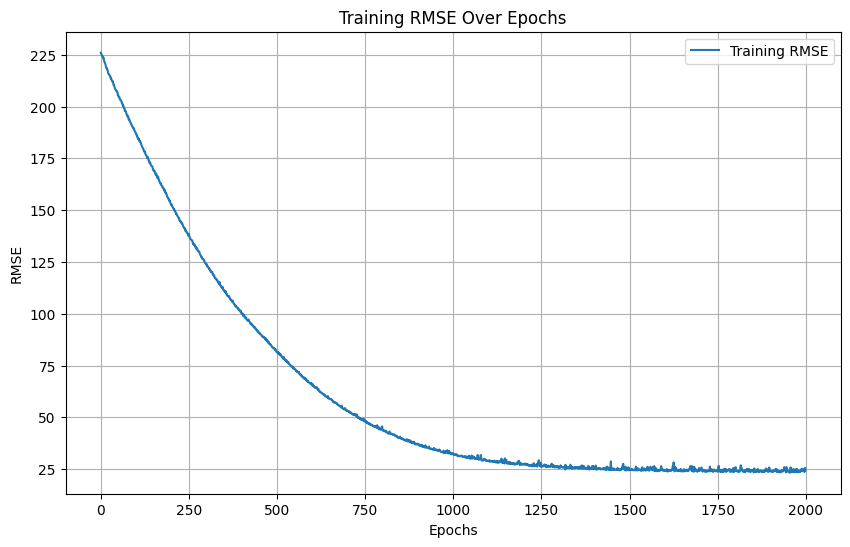

In [33]:
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label="Training RMSE")
plt.title("Training RMSE Over Epochs")
plt.xlabel("Epochs")
plt.ylabel("RMSE")
plt.legend()
plt.grid(True)
plt.show()

**Model Accuracy Analysis:**

The model learned but its accuracy is not ideal, as indicated by a high RMSE on test data, significantly higher than expected.

High RMSE: Indicates a large deviation from actual values. For example, an RMSE of 100 means the predictions differ from actual values by approximately 100,000 passengers.

**Possible Reasons:**

1. Overfitting: The model performs well on training data but poorly generalizes on new (test) data, indicating overfitting.

**Improvement Paths:**

1. Regularization: Apply methods like L2 regularization.
2. Data Normalization: Include data normalization.
3. Training Process Adjustment: Improve the training process for better generalization and reduced error on test data.


Модель навчилась, але не факт, що точно)

Доволі неочікувано, що середньоквадратичне відхилення тестового набору даних буде на порядок більшим за одиниці в нашому наборі даних. Середньоквадратичне відхилення 100 означає, що прогноз і фактичне значення будуть відрізнятися в середньому на 100 (тобто, 100 000 пасажирів у цьому наборі даних).



Щоб краще зрозуміти якість прогнозу, ви можете побудувати графік з кодом нижче (а ще нижче - описано, що відбувається в цьому коді, бо це теж корисно зрозуміти):

In [34]:
timeseries = passengers_array

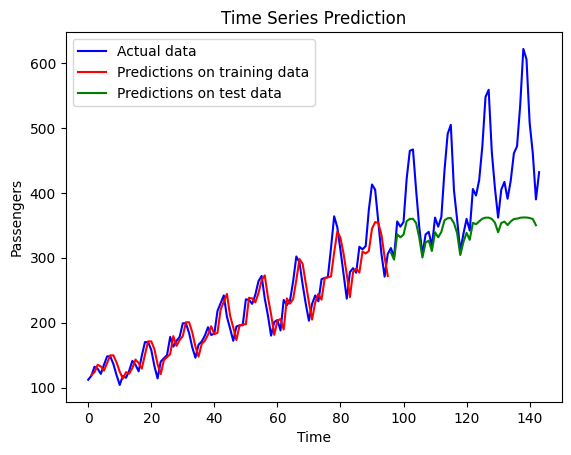

In [35]:
def plot_predicts():
    with torch.no_grad():  # Disable gradient calculation for predictions

        # Get the size of the training set
        train_size = len(X_train)

        # Create placeholders for predictions
        train_plot = np.ones_like(timeseries) * np.nan
        test_plot = np.ones_like(timeseries) * np.nan

        # Generate predictions for the training data
        y_pred_train = model(X_train)
        train_plot[lookback:lookback + train_size] = y_pred_train[:, -1].numpy()

        # Generate predictions for the test data
        y_pred_test = model(X_test)
        test_plot[lookback + train_size:lookback + train_size + len(X_test)] = y_pred_test[:, -1].numpy()

        # Visualization of real data and predictions
        plt.plot(timeseries, color='b', label='Actual data')
        plt.plot(train_plot, color='r', label='Predictions on training data')
        plt.plot(test_plot, color='g', label='Predictions on test data')

        plt.title('Time Series Prediction')
        plt.xlabel('Time')
        plt.ylabel('Passengers')
        plt.legend()
        plt.show()

# Call the function to plot predictions
plot_predicts()

**Що відбувається в коді вище.** В цьому коді здійснюється процес прогнозування часових рядів за допомогою LSTM моделі, а також виведення графіку, який показує реальні значення, тренувальні та тестові прогнози. Ось що відбувається на кожному етапі:

1. **`torch.no_grad()`**: Цей контекстний менеджер вимикає обчислення градієнтів, що означає, що під час прогнозування не будуть зберігатися проміжні обчислення для зворотного проходу (backpropagation). Це підвищує ефективність під час прогнозування і зменшує використання пам'яті.

2. **Зсув прогнозів для тренувальних даних:**
   - Створюється масив `train_plot`, який має такий самий розмір, як і часовий ряд (`timeseries`), і заповнюється значеннями NaN (`np.nan`), щоб залишити місце для реальних значень.
   - Модель передбачає виходи для тренувальних даних `X_train`.
   - Використовується лише останнє передбачене значення для кожного входу LSTM (`y_pred[:, -1]`).
   - Прогнози зсуваються, починаючи з індексу `lookback` до кінця тренувальних даних (індекс `train_size`). Цей зсув потрібен, щоб зробити прогноз на основі попередніх даних і відобразити його на правильній частині графіку.

3. **Зсув прогнозів для тестових даних:**
   - Створюється масив `test_plot`, який також заповнюється NaN.
   - Прогнози для тестових даних додаються з індексу `train_size + lookback` до кінця реальних даних, щоб відобразити, де модель починає прогнозувати тестову вибірку.

4. **Побудова графіка:**
   - `plt.plot(timeseries, c='b')`: Виводить реальні значення часового ряду (синя лінія).
   - `plt.plot(train_plot, c='r')`: Виводить тренувальні прогнози (червона лінія).
   - `plt.plot(test_plot, c='g')`: Виводить тестові прогнози (зелена лінія).

**Чому це робиться:**
- Зсув прогнозів для тренувальних і тестових даних дозволяє візуально зрівняти, наскільки добре модель прогнозує як на тренувальній, так і на тестовій вибірках. Зазвичай, червона лінія (тренувальні прогнози) повинна точно відповідати синій лінії (реальні дані), а зелена лінія (тестові прогнози) дає змогу побачити, наскільки модель добре працює на нових даних, яких вона раніше не бачила.

**Завдання 8**. Навчіть модель з hidden_size=100 та порівняйте результати прогнозів з попередніми.

In [36]:
# Define a new model with hidden_size=100
model = AirModel(hidden_size=100, num_layers=1)

# Initialize the optimizer again since we have a new model
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Set the model to training mode
model.train()

# Number of epochs
epochs = 2000

# Store losses
train_losses = []

# Training loop
for epoch in range(epochs):
    epoch_train_loss = 0

    # Training
    for X_batch, y_batch in train_loader:
        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        y_pred = model(X_batch)

        # Compute the loss
        loss = criterion(y_pred, y_batch)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Accumulate the training loss
        epoch_train_loss += loss.item()

    # Calculate average training RMSE
    avg_train_rmse = math.sqrt(epoch_train_loss / len(train_loader))

    # Every 100 epochs, evaluate on the validation set
    if (epoch + 1) % 100 == 0:
        model.eval()  # Set the model to evaluation mode
        val_loss = 0

        with torch.no_grad():  # Disable gradient calculations
            for X_batch, y_batch in test_loader:
                # Forward pass
                y_pred = model(X_batch)

                # Compute validation loss
                val_loss += criterion(y_pred, y_batch).item()

        # Calculate RMSE for the validation set
        avg_val_rmse = math.sqrt(val_loss / len(test_loader))

        # Print RMSE for both training and validation
        print(f"Epoch {epoch+1}: train RMSE {avg_train_rmse:.4f}, test RMSE {avg_val_rmse:.4f}")

        model.train()  # Switch back to training mode

    # Save training RMSE for each epoch
    train_losses.append(avg_train_rmse)

Epoch 100: train RMSE 153.3781, test RMSE 347.0857
Epoch 200: train RMSE 104.8631, test RMSE 290.3834
Epoch 300: train RMSE 74.9583, test RMSE 247.1514
Epoch 400: train RMSE 53.6670, test RMSE 210.3781
Epoch 500: train RMSE 40.1630, test RMSE 180.6396
Epoch 600: train RMSE 33.3064, test RMSE 157.1693
Epoch 700: train RMSE 28.6270, test RMSE 138.5423
Epoch 800: train RMSE 28.4039, test RMSE 125.5578
Epoch 900: train RMSE 28.7142, test RMSE 117.5135
Epoch 1000: train RMSE 24.6025, test RMSE 108.4739
Epoch 1100: train RMSE 25.0344, test RMSE 102.8563
Epoch 1200: train RMSE 23.7924, test RMSE 99.7398
Epoch 1300: train RMSE 24.9153, test RMSE 96.7551
Epoch 1400: train RMSE 24.5843, test RMSE 97.6887
Epoch 1500: train RMSE 23.4725, test RMSE 93.3937
Epoch 1600: train RMSE 23.3978, test RMSE 91.7951
Epoch 1700: train RMSE 23.4144, test RMSE 92.6365
Epoch 1800: train RMSE 25.4704, test RMSE 94.2672
Epoch 1900: train RMSE 24.0757, test RMSE 93.4550
Epoch 2000: train RMSE 26.4212, test RMSE 90.0

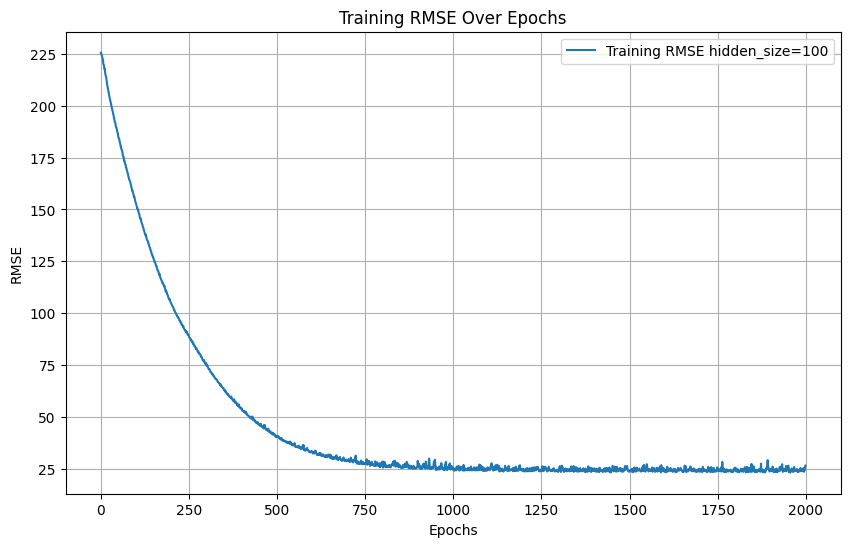

In [37]:
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label="Training RMSE hidden_size=100")
plt.title("Training RMSE Over Epochs")
plt.xlabel("Epochs")
plt.ylabel("RMSE")
plt.legend()
plt.grid(True)
plt.show()

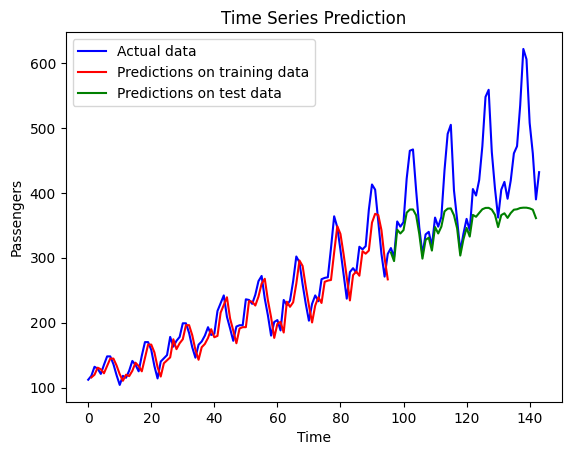

In [38]:
# Call the function to plot predictions
plot_predicts()

**Model Comparison Conclusions:**

**1. RMSE:**

**First Model (hidden_size=50):**

Training RMSE: Stabilizes around 24 after 2000 epochs.

Test RMSE: Starts very high (over 350) and reduces to about 100 by the end of training, indicating overfitting.

**Second Model (hidden_size=100):**

Training RMSE: Similarly stabilizes around 24 after 2000 epochs.

Test RMSE: Decreases more rapidly, reaching around 90, slightly better than the first model.

**2. Prediction Graphs:**

Both models follow real data closely on the training set (red line), but deviate on the test set (green line), especially in later stages with higher passenger numbers.

The second model (hidden_size=100) better captures trends on the test set, particularly in the first half.

**Overall Conclusions:**

1. Both models perform well on training data but struggle with generalization on test data, indicating overfitting.
2. The second model (hidden_size=100) shows slightly better results on test data, with RMSE reducing to 90 (versus 100 for the first model).
3. Regularization methods or more training data might help reduce overfitting and improve generalization on test data.
